 Libraries Import


In [1]:
import pandas as pd
import numpy as np
import csv
import seaborn as sns
import ast
from collections import defaultdict
import matplotlib.pyplot as plt
from IPython.display import HTML
import project_tests as t
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
%matplotlib inline


Data Loads

In [62]:
df = pd.read_csv("user-item-interactions.csv")
df_content = pd.read_csv("articles_community.csv")
del df['Unnamed: 0']
del df_content['Unnamed: 0']


In [3]:
# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [4]:
# Show df_content to get an idea of the data
df_content.head()


,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


Exploratory Data Analysis


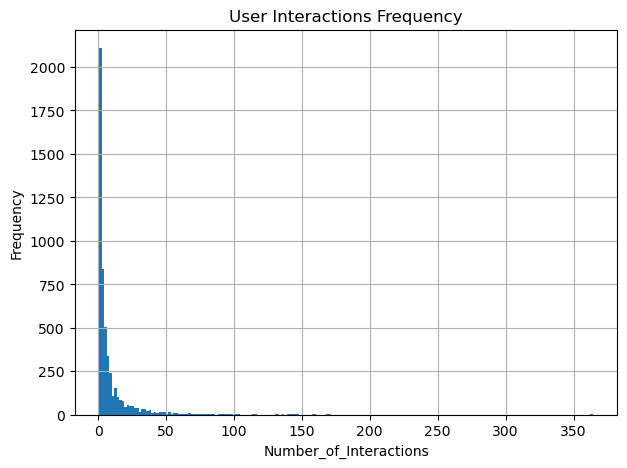

In [5]:
def frequency_distribution_plt():
    """
    Input:
          None
    Output:
          Frequency Distribution plot depicting the number of user interactions frequency for each article.  
    """
    plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100}) 
    article_interactions = pd.crosstab(df.email, columns=[df.article_id]).T.sum()
    article_interactions.hist(bins=200)
    plt.gca().set(title='User Interactions Frequency',xlabel='Number_of_Interactions', ylabel='Frequency');    
    
frequency_distribution_plt()
    




In [63]:
article_interactions = pd.crosstab(df.email, columns=[df.article_id]).T.sum()

In [64]:
# Fill in the median and maximum number of user_article interactios below
#50% of individuals interact with _3___ number of articles or fewer.
article_interactions.describe()



count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
dtype: float64

In [65]:
article_interactions.value_counts().max()
# The maximum number of user-article interactions by any 1 user is 364______.


1416

In [10]:
# Find and explore duplicate articles
print(df_content[df_content.duplicated(subset='article_id',keep='first')])


                                              doc_body  \
365  Follow Sign in / Sign up Home About Insight Da...   
692  Homepage Follow Sign in / Sign up Homepage * H...   
761  Homepage Follow Sign in Get started Homepage *...   
970  This video shows you how to construct queries ...   
971  Homepage Follow Sign in Get started * Home\r\n...   

                                       doc_description  \
365  During the seven-week Insight Data Engineering...   
692  One of the earliest documented catalogs was co...   
761  Today’s world of data science leverages data f...   
970  This video shows you how to construct queries ...   
971  If you are like most data scientists, you are ...   

                                         doc_full_name doc_status  article_id  
365                       Graph-based machine learning       Live          50  
692  How smart catalogs can turn the big data flood...       Live         221  
761  Using Apache Spark as a parallel processing fr...       L

In [11]:
# Remove any rows that have the same article_id - only keep the first
df_content= df_content.drop_duplicates(subset='article_id',keep='first',inplace=False)


In [12]:
# Checking back for any duplicate rows for article_id
print(df_content[df_content.duplicated(subset='article_id',keep=False)])

Empty DataFrame
Columns: [doc_body, doc_description, doc_full_name, doc_status, article_id]
Index: []


In [13]:
# The number of unique articles that have at least one interaction
article_interactions = pd.crosstab(df.email, columns=[df.article_id],dropna=True).sum()
article_interactions[article_interactions >0].size



714

In [14]:
# The number of unique articles on the IBM platform
print(df_content.article_id.nunique())

1051


In [15]:
# The number of unique users
print(df.email.nunique())

5148


In [32]:
# The number of user-article interactions
df.shape[0]

45993

In [16]:
unique_articles = 714 # The number of unique articles that have at least one interaction
total_articles =1051 # The number of unique articles on the IBM platform
unique_users = 5148 # The number of unique users
user_article_interactions = 45993 # The number of user-article interactions

In [17]:
# The most viewed article in the dataset as a string with one value following the decimal 
article_interactions.sort_values(ascending=False).iloc[:10] 


article_id
1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
dtype: int64

In [32]:
# The most viewed article in the dataset was viewed how many times?
max_views_by_user = article_interactions.max()


In [20]:
most_viewed_article_id = '1429.0' # The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937 # The most viewed article in the dataset was viewed how many times?

Rank Based Recommendation 

In [76]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [73]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': 3,
    '`The total number of user-article interactions in the dataset is ______.`': 45993,
    '`The maximum number of user-article interactions by any 1 user is ______.`': 364,
   '`The most viewed article in the dataset was viewed _____ times.`': 937,
    '`The article_id of the most viewed article is ______.`': '1429.0',
    '`The number of unique articles that have at least 1 rating ______.`': 714,
    '`The number of unique users in the dataset is ______`': 5148,
    '`The number of unique articles on the IBM platform`': 1051
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


Part II: Rank-Based Recommendations
Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not. We only know that a user has interacted with an article. In these cases, the popularity of an article can really only be based on how often an article was interacted with.

1. Fill in the function below to return the n top articles ordered with most interactions as the top. Test your function using the tests below.

In [77]:
def get_top_articles(n,df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    
    article_interactions = pd.crosstab(df.user_id, columns=[df.title]).sum()
    top_articles = article_interactions.nlargest(n).index.tolist()
             
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
   
    article_interactions = pd.crosstab(df.user_id, columns=[df.article_id]).sum()
    top_articles = article_interactions.nlargest(n).index.tolist()
 
    return top_articles # Return the top article ids



In [78]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [79]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


Part III: User-User Based Collaborative Filtering
1. Use the function below to reformat the df dataframe to be shaped with users as the rows and articles as the columns.

Each user should only appear in each row once.
Each article should only show up in one column.
If a user has interacted with an article, then place a 1 where the user-row meets for that article-column. It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.
If a user has not interacted with an item, then place a zero where the user-row meets for that article-column.
Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [80]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
        df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
        user_item - user item matrix 
    
    Description:
        Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
        an article and a 0 otherwise
    '''
    
    # Fill in the function here
    user_item = pd.crosstab(df.user_id, columns=[df.article_id])
    user_item[user_item > 0] = 1  
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [24]:
#Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


In [81]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    similarity = user_item[user_item.index != user_id].dot(user_item.loc[user_id])
    most_similar_users = similarity.sort_values(ascending=False).index.tolist()
    

    # sort by similarity

    # create list of just the ids
   
    # remove the own user's id
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [82]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 46, 4201, 395]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


In [83]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''

    df.article_id = df.article_id.astype(str)
    
    article_names = (df
                     .drop_duplicates('article_id')
                     .set_index('article_id')
                     .loc[article_ids]
                     .title
                     .tolist()
                    )
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''


    users = user_item.loc[user_id] 
    article_ids = users[users==1].index.tolist()
    article_ids = [str(j)for j in article_ids]   
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''

    articles  = get_user_articles(user_id)[0]
    all_users = find_similar_users(user_id)
    
    recs = []
    for user in all_users:
        rec_articles = get_user_articles(user)[0]

        for article in rec_articles:
            if article not in articles and article not in recs:
                recs.append(article)
                if len(recs) == m:
                    return recs # return your recommendations for this user_id  def get_article_names(article_ids, df=df):
    

In [84]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['this week in data science (april 18, 2017)',
 'timeseries data analysis of iot events by using jupyter notebook',
 'got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'higher-order logistic regression for large datasets',
 'using machine learning to predict parking difficulty',
 'deep forest: towards an alternative to deep neural networks',
 'experience iot with coursera',
 'using brunel in ipython/jupyter notebooks',
 'graph-based machine learning',
 'the 3 kinds of context: machine learning and the art of the frame']

In [32]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


In [85]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Your code here
    neighbors_df = pd.DataFrame()
    similarity = user_item[user_item.index != user_id].dot(user_item.loc[user_id])
    unique_similarity = similarity.sort_values(ascending=False)
    
    neighbors_df['neighbor_id'] = unique_similarity.index.tolist()
    neighbors_df['similarity'] = unique_similarity.tolist()
    neighbors_df['num_interactions'] = neighbors_df['neighbor_id'].apply(lambda i: df[df['user_id'] == i].shape[0])
    
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Your code here
    all_articles  = get_user_articles(user_id)[0]
    users = get_top_sorted_users(user_id)['neighbor_id']

    recs = []
    users_dict = defaultdict(list)
    for user in users:
        if len(recs) <= m:
            rec_articles = get_user_articles(user)[0]
        
            for article in rec_articles:
                if article not in all_articles and article not in recs:
                # Keep track of users and articles
                    users_dict[user].append(article)
                    recs.append(article)
                    
                    
    top_articles = get_top_article_ids(df.shape[0])
    # Dictionary for ranking top articles
    top_articles_dict = {article:i for i, article in enumerate(top_articles)}
    
    # remove the final user articles
    final_user_articles = len(users_dict[user])
    recs = recs[:-final_user_articles]
    
    
    # sort rec_articles of the final user based on top articles
    sort_articles = [(article, top_articles_dict[article]) for article in rec_articles]
    sort_articles.sort(key=lambda x: x[1])
    for article_tuple in sort_articles:
        article = article_tuple[0]
        if article not in all_articles and article not in recs:
            recs.append(article)
            if len(recs) == m:
                return recs,  get_article_names(recs) # return your recom

In [35]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1429.0', '1330.0', '1314.0', '1293.0', '1162.0', '1271.0', '43.0', '1351.0', '1368.0', '1305.0']

The top 10 recommendations for user 20 are the following article names:
['use deep learning for image classification', 'insights from new york car accident reports', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'analyze energy consumption in buildings', 'customer demographics and sales', 'deep learning with tensorflow course by big data university', 'model bike sharing data with spss', 'putting a human face on machine learning', 'gosales transactions for naive bayes model']


In [38]:
### Tests with a dictionary of results
get_top_sorted_users(1).head(1)


,neighbor_id,similarity,num_interactions
0,3933,35,45


In [39]:
get_top_sorted_users(131).head(10)

,neighbor_id,similarity,num_interactions
0,3870,74,144
1,3782,39,363
2,23,38,364
3,203,33,160
4,4459,33,158
5,49,29,147
6,3764,29,169
7,3697,29,145
8,98,29,170
9,3910,25,147


In [86]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': 3933, 
    'The user that is the 10th most similar to user 131': 242,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


In [36]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10) # Your recommendations here
print(new_user_recs)
get_top_articles(10)

['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


['use deep learning for image classification',
 'insights from new york car accident reports',
 'visualize car data with brunel',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'predicting churn with the spss random tree algorithm',
 'healthcare python streaming application demo',
 'finding optimal locations of new store using decision optimization',
 'apache spark lab, part 1: basic concepts',
 'analyze energy consumption in buildings',
 'gosales transactions for logistic regression model']

In [37]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


Content Based Recommendations (EXTRA - NOT REQUIRED)


Content Based Recommendation 
For the purpose of content based recommendation system, I have utilzed sentence-transformers algorithim along with the cosine similarity recommendation system for identifying textual patterns on the bais of article decritpion and article full name used by the users.  

Data Preprocessing
For running a content based recommendation system we will use doc_description,doc_full_name,article_id fields from the df_content dataframe.

In [43]:
df_content_copy =  df_content[['doc_description','doc_full_name','article_id']]
df_content_copy = df_content_copy.dropna()
df_content_copy = df_content_copy.reset_index(drop=True)

In [44]:
X = np.array(df_content_copy.doc_description)
text_data = X
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(text_data, show_progress_bar=True)

X = np.array(embeddings)
cos_sim_data =  pd.DataFrame(cosine_similarity(X)) 


Batches:   0%|          | 0/33 [00:00<?, ?it/s]

In [45]:
def make_content_recs(index,print_recommendation=False,print_recommendation_plots=False):
    """
    This function will parse through the cosine similarity matrix to find the optimal reccommendation for the new users.
    Input:
          index - The index range from the cos sim data matrix
          print recommendation = False
          print recommendation = False
    Output:
         Recommendation List of index numbers along with the article names primaly viewed by the user
    """
    
    index_recomm = cos_sim_data.loc[index].sort_values(ascending=False).index.tolist()[1:10]
    article_recomm =  df_content_copy['doc_full_name'].loc[index_recomm].values
    result = {'Articles':article_recomm,'Index':index_recomm}
    if print_recommendation==True:
        print('The Article is this one: %s \n'%(df_content_copy['doc_full_name'].loc[index]))
        k=1
        for article in article_recomm:
            print('The number %i recommended article is this one: %s \n'%(k,article))
    if print_recommendation_plots==True:
        print('The plot of the viewed article is this one:\n %s \n'%(df_content_copy['doc_description'].loc[index]))
        k=1
        for q in range(len(article_recomm)):
            plot_q = df_content_copy['doc_description'].loc[index_recomm[q]]
            print('The plot of the number %i recommended article is this one:\n %s \n'%(k,plot_q))
            k=k+1
    return result
        

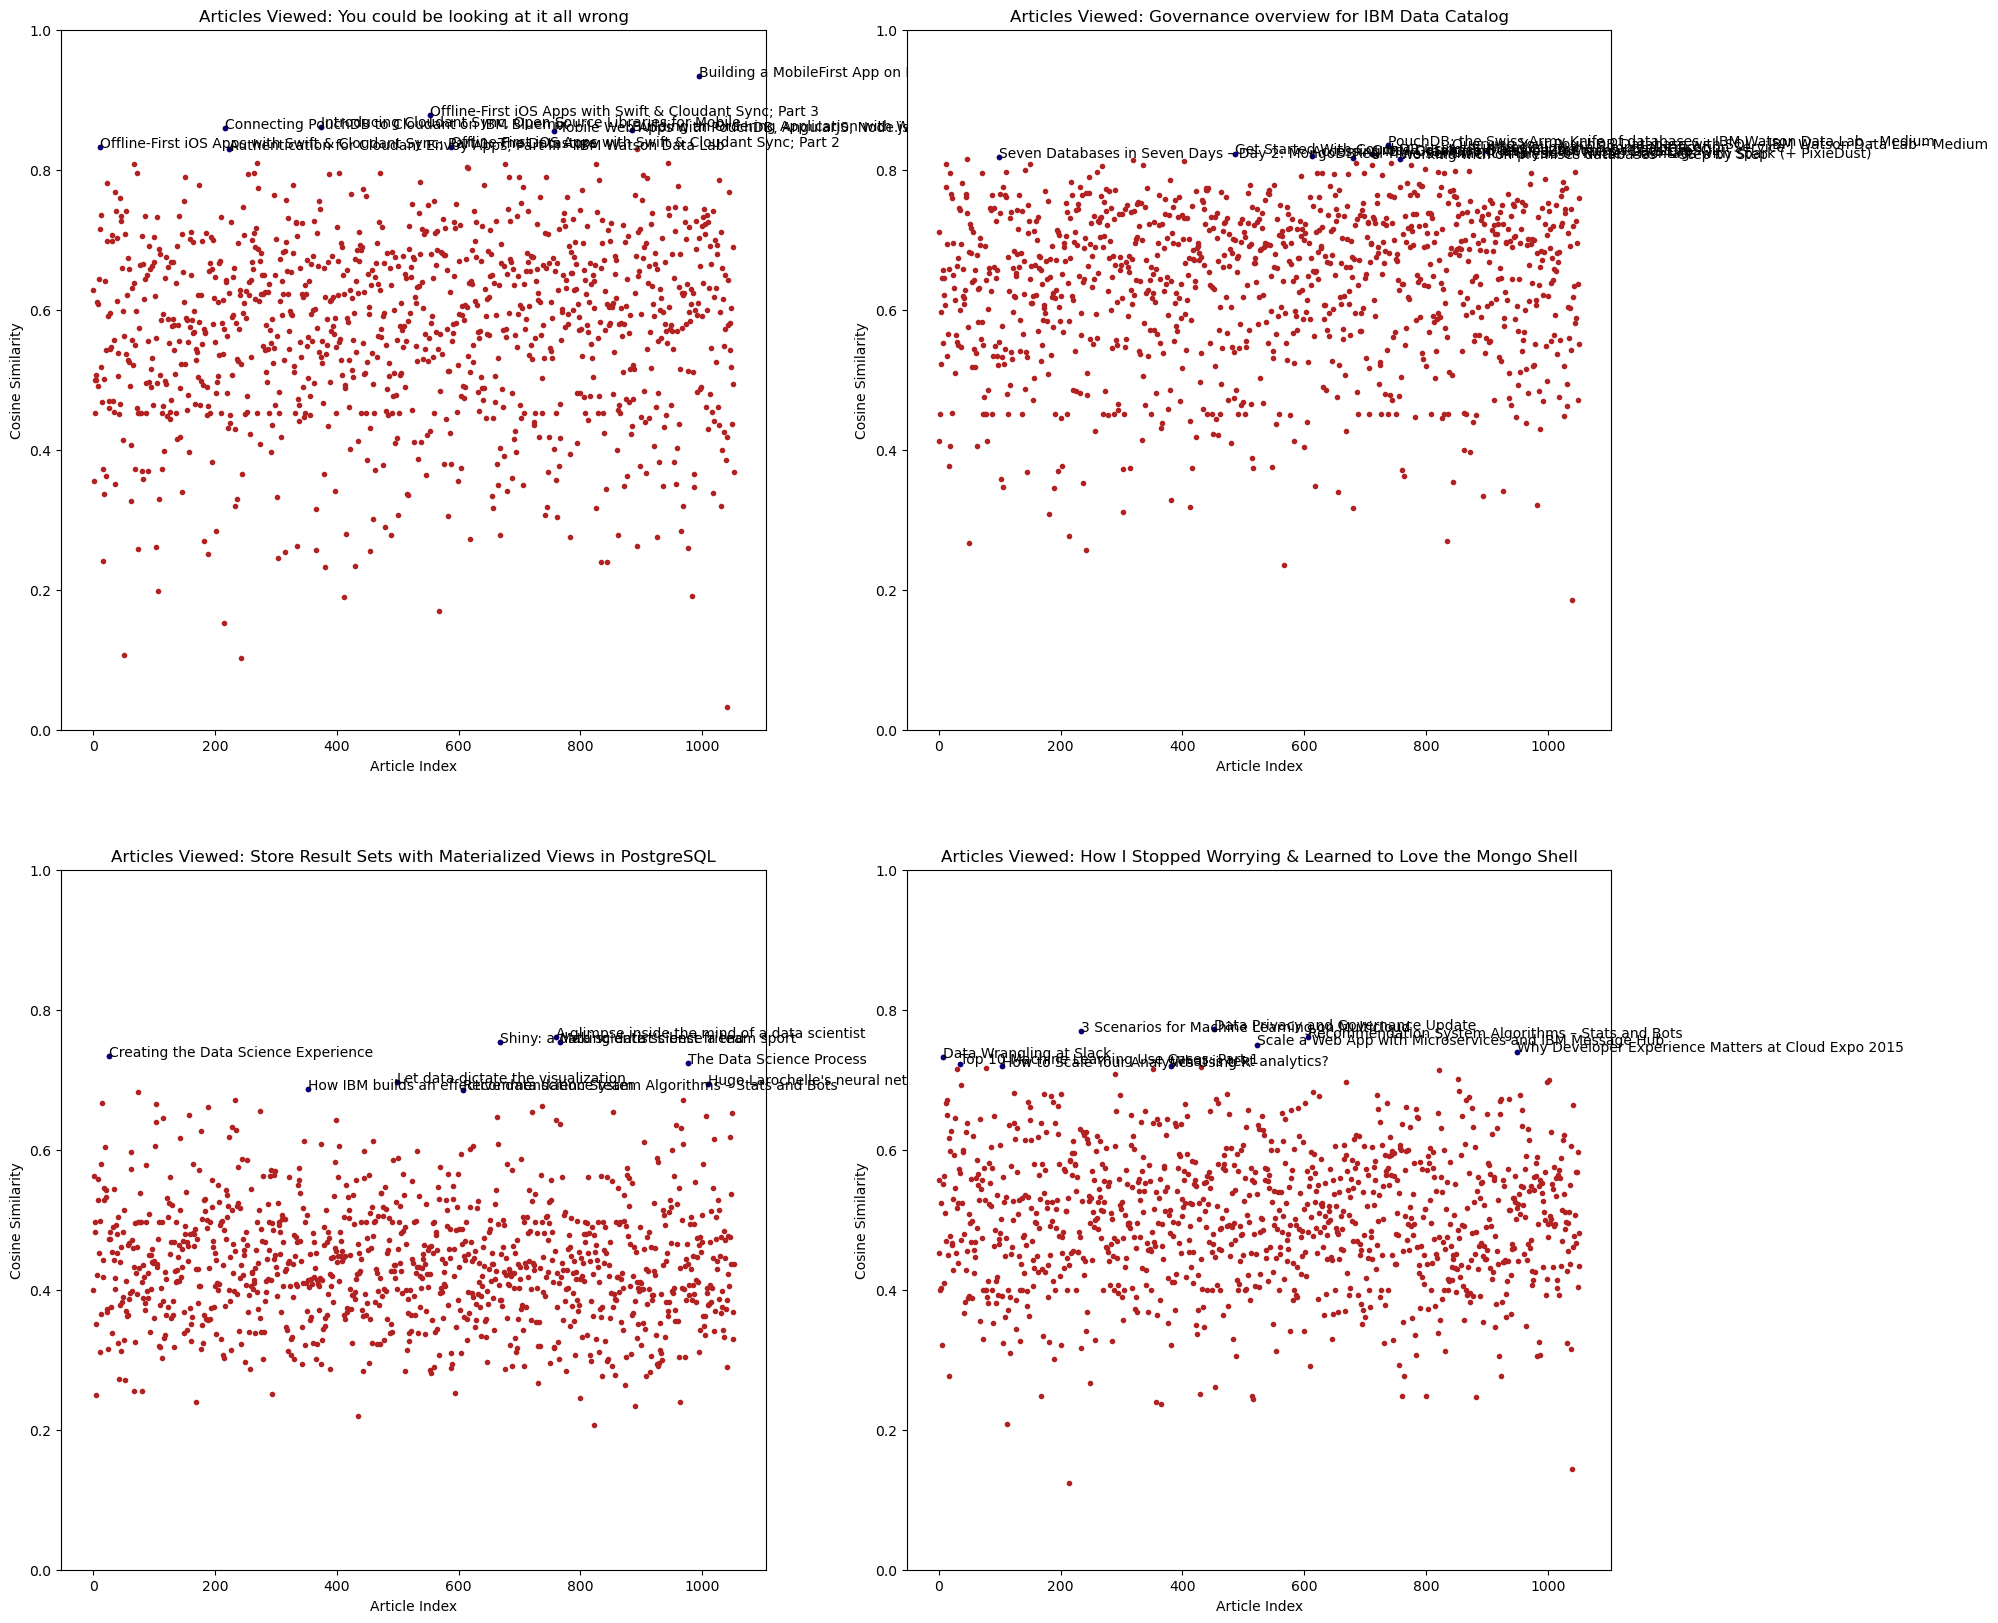

In [46]:
plt.figure(figsize=(20,20))
for q in range(1,5):
    plt.subplot(2,2,q)
    index = np.random.choice(np.arange(0,len(X)))
    to_plot_data = cos_sim_data.drop(index,axis=1)
    plt.plot(to_plot_data.loc[index],'.',color='firebrick')
    recomm_index = make_content_recs(index)
    x = recomm_index['Index']
    y = cos_sim_data.loc[index][x].tolist()
    m = recomm_index['Articles']
    plt.plot(x,y,'.',color='navy',label='Recommended Articles')
    plt.title('Articles Viewed: '+ df_content['doc_full_name'].loc[index])
    plt.xlabel('Article Index')
    k=0
    for x_i in x:
        plt.annotate('%s'%(m[k]),(x_i,y[k]),fontsize=10)
        k=k+1
        

    plt.ylabel('Cosine Similarity')
    plt.ylim(0,1)

In [56]:
make_content_recs(3,True,True)


The Article is this one: DataLayer Conference: Boost the performance of your distributed database 

The number 1 recommended article is this one: A look under the covers of PouchDB-find 

The number 1 recommended article is this one: What is Spark? 

The number 1 recommended article is this one: A Moving Average Trading Strategy 

The number 1 recommended article is this one: Pulling and Displaying ETF Data 

The number 1 recommended article is this one: Tidyverse practice: mapping large European cities 

The number 1 recommended article is this one: Convert data from Oracle to dashDB 

The number 1 recommended article is this one: Creating an AWS VPC and Secured Compose MongoDB with Terraform 

The number 1 recommended article is this one: Data Wrangling with dplyr and tidyr Cheat Sheet 

The number 1 recommended article is this one: Building Instant RESTFul API's with MongoDB and RESTHeart 

The plot of the viewed article is this one:
 Learn how distributed DBs solve the problem of s

{'Articles': array(['A look under the covers of PouchDB-find', 'What is Spark?',
        'A Moving Average Trading Strategy',
        'Pulling and Displaying ETF Data',
        'Tidyverse practice: mapping large European cities',
        'Convert data from Oracle to dashDB',
        'Creating an AWS VPC and Secured Compose MongoDB with Terraform',
        'Data Wrangling with dplyr and tidyr Cheat Sheet',
        "Building Instant RESTFul API's with MongoDB and RESTHeart"],
       dtype=object),
 'Index': [1048, 463, 485, 39, 585, 539, 196, 215, 793]}

Output Observation
The algorithim recommends that if a new user have previously interacted or read  "DataLayer Conference: Boost the performance of your distributed database" article then artcile recommendations as listed below can will be of high interest to the new user:
"A look under the covers of PouchDB-find",
"What is Spark?", "A Moving Average Trading Strategy",
"Pulling and Displaying ETF Data",
"mapping large European cities",
"Convert data from Oracle to dashDB",
"Creating an AWS VPC and Secured Compose MongoDB with Terraform" 
"Building Instant RESTFul API's with MongoDB and RESTHeart"   

This recommendation by the algorithm seems to be preety spot on as the content of the reccommeded articles is highly correlated with the article that user have recently interacted. 
 

Part V: Matrix Factorization
In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

1. You should have already created a user_item matrix above in question 1 of Part III above. This first question here will just require that you run the cells to get things set up for the rest of Part V of the notebook.

In [87]:
# Load the matrix here
user_item_matrix = pd.read_pickle("D:\\Udacity\\Experiment_Reccommendation_Design\\IBM_RecommendationEngine\\user_item_matrix.p")

In [88]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


2. In this situation, you can use Singular Value Decomposition from numpy on the user-item matrix. Use the cell to perform SVD, and explain why this is different than in the lesson.

In [89]:
# Perform SVD on the User-Item Matrix Here
u, s, vt = np.linalg.svd(user_item_matrix,full_matrices=False)# use the built in to get the three matrices

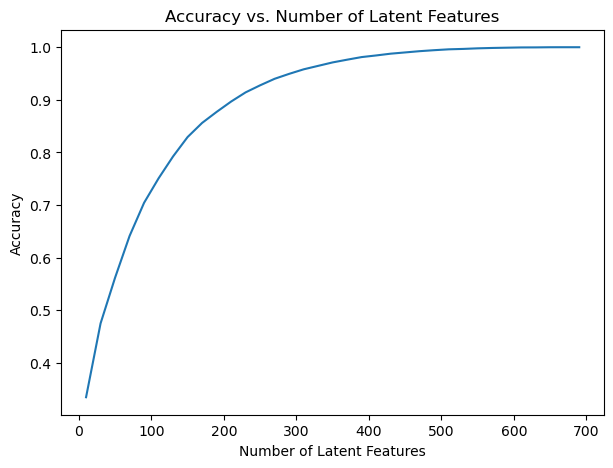

In [90]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

In [91]:
df_train = df.head(40000)
df_test = df.tail(5993)
def create_test_and_train_user_item(df_train, df_test):
    
    '''
    INPUT:
        df_train - training dataframe
        df_test - test dataframe
    
    OUTPUT:
        user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
        user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
        test_idx - all of the test user ids
        test_arts - all of the test article ids
    
    '''
    # Your code here
    ## Finding users with matching index's    
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    
    train_index = set(user_item_train.index)
    test_index = set(user_item_test.index)
    matching_index = train_index.intersection(test_index)
    
    
    
    ## Finding records in both train and test data sets   
    train_arts = set(user_item_train.columns)    
    test_arts = set(user_item_test.columns) 
    matching_cols = train_arts.intersection(test_arts)
    
    user_item_test = user_item_test.loc[matching_index,matching_cols]
    
    
    return user_item_train, user_item_test, test_index, test_arts

user_item_train, user_item_test, test_index, test_arts = create_test_and_train_user_item(df_train, df_test)


C:\Users\rhnne\AppData\Local\Temp\ipykernel_21996\2373840252.py:36: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  user_item_test = user_item_test.loc[matching_index,matching_cols]


In [65]:
#How many users can we make predictions for in the test set?
user_item_test.shape[0]

20

In [414]:
#How many users in the test set are we not able to make predictions for because of the cold start problem?'
len(test_index) - user_item_test.shape[0]

662

In [415]:
user_item_test.shape[1]

574

In [416]:
len(test_arts) - user_item_test.shape[1]

0

In [92]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': 20, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': 662, 
    'How many articles can we make predictions for in the test set?':574,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': 0
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


In [94]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)# fit svd similar to above then use the cells below

In [ ]:
# Use these cells to see how well you can use the training decomposition to predict on test data

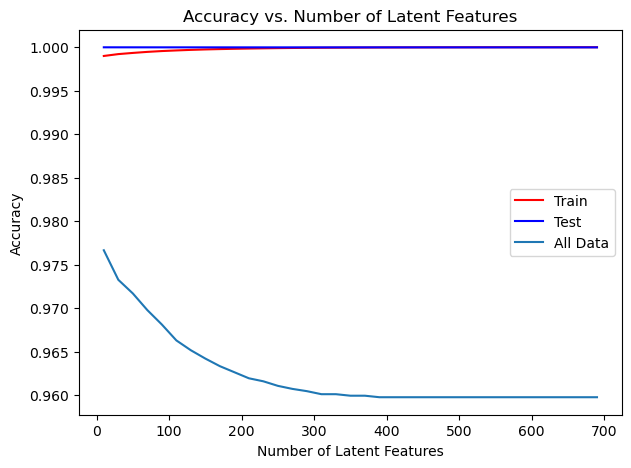

In [96]:
row_index = user_item_train.index.isin(test_index)
cols_index = user_item_train.columns.isin(test_arts)
u_test = u_train[row_index,:]
vt_test = vt_train[:,cols_index]


num_latent_feats = np.arange(10,700+10,20)
sum_errs_train = []
sum_errs_test = []
errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_train_lat, u_train_lat, vt_train_lat = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_test_lat,vt_test_lat = u_test[:, :k], vt_test[:k, :]
    
    # take dot product
    user_item_train_pred = np.around(np.dot(np.dot(u_train_lat, s_train_lat), vt_train_lat))
    user_item_test_pred =  np.around(np.dot(np.dot(u_test_lat, s_train_lat), vt_test_lat))
    errs.append(1 - ((np.sum(user_item_test_pred)+np.sum(np.sum(user_item_test)))/(user_item_test.shape[0]*user_item_test.shape[1])))
                     
                                     
                                     
    
    # compute error for each prediction to actual value
    diffs_train  = np.subtract(user_item_train, user_item_train_pred)
    diffs_test  = np.subtract(user_item_test, user_item_test_pred)
    
    # total errors and keep track of them
    train_err = np.sum(np.sum(np.abs(diffs_train)))
    test_err = np.sum(np.sum(np.abs(diffs_test)))
    
    sum_errs_train.append(train_err)
    sum_errs_test.append(test_err)
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs_train)/(df.shape[0] * user_item_test.shape[1]), label='Train', color='r');
plt.plot(num_latent_feats, 1 - np.array(sum_errs_test)/(df.shape[0] * user_item_test.shape[1]), label='Test', color='b');
plt.plot(num_latent_feats, errs, label='All Data');
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');
plt.legend();

Conclusion

The accuracy of alomost 100% with around 300 latent features, appears to be good but also seems to non-semitrical especially when the size of test users is only 20 users and there is inbalanced in class as we only account for 1's which is approximatly 1% of the dataset. In order to get the better understanding the accuracy and prediction boundary of individual data elements   calculating precision, recall and support table will be a better approach for this issue.
Setting up an online experiment where users are randomly split and assigned to control group with no recommendations and another group that is given recommendations can prove to suitable solution to this problem. It will be fare to conclude with that the null hypothesis of no difference between the two groups in terms of nuber of users interactions and thus fail to say that there is any statistical significant user recommendations.
